<div class="alert alert-block alert-success">
    <b>Artifical Intelligence, Project: Medical Image Classification</b> <br>
Ghent University <br>
AY 2024/2025 <br>
Axelle Petit, Robbe Goeminne, Fien Geukens, Arthur Dhont
</div>

## 1. Data exploration, pre-processing and Augmentation

### 1.0. Imports

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import imblearn
import yaml

print("numpy:", np.__version__)
print("tensorflow:", tf.__version__)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("pyaml:", yaml.__version__)

#!pip install pyaml==25.1.0

numpy: 1.26.4
tensorflow: 2.16.2
scikit-learn: 1.6.1
pandas: 2.2.3
matplotlib: 3.10.0
seaborn: 0.13.2
imbalanced-learn: 0.13.0
pyaml: 6.0.2


In [54]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

### 1.1. Loading the data

In [57]:
#set the paths/directories
path = Path('covid xray')
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'val')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

#### 1.1.1. Set up image generators

In [60]:
#use ImageDataGenerator to read image and transform them into a tensor
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)

#### 1.1.2. Load as arrays

In [63]:
batch_size = 128
img_height = img_width = 299

In [65]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')
#Flow from directory function: 
#Loads images in batches
#Resizes them to target_size
#Labels them based on the subfolder names.
#Returns an iterator you can use directly in model.fit().

Found 1600 images belonging to 2 classes.


In [67]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

Found 400 images belonging to 2 classes.


### 1.2. Data Exploration

#### 1.2.1 Training dataset Size

In [71]:
# Check how many images you have in training data
num_covid_imgs = len(os.listdir(train_covid_dir))
num_normal_imgs = len(os.listdir(train_normal_dir))

print(f'COVID training images: {num_covid_imgs}')
print(f'NORMAL training images: {num_normal_imgs}')


COVID training images: 800
NORMAL training images: 800


#### 1.2.2. Check whether the images have the same size

In [74]:
#Check for COVID images (training data)
folder = 'covid xray/train/COVID' 
sizes = set() #sets do not allow duplicate values.
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")
#Check for COVID images (validation data)
folder = 'covid xray/val/COVID' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}
Unique image sizes: {(299, 299)}


In [75]:
#Check for NORMAL images (training data)
folder = 'covid xray/train/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

#Check for NORMAL images (val data)
folder = 'covid xray/val/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}
Unique image sizes: {(299, 299)}


#### 1.2.3. Distribution of two classes

In [79]:
# Check how many images you have in validation data
num_covid_imgs_val = len(os.listdir(validation_covid_dir))
num_normal_imgs_val = len(os.listdir(validation_normal_dir))

print(f'COVID training images: {num_covid_imgs}')
print(f'NORMAL training images: {num_normal_imgs}')

print(f'COVID validation images: {num_covid_imgs_val}')
print(f'NORMAL validation images: {num_normal_imgs_val}')

print("--")

total_train = num_covid_imgs + num_normal_imgs
total_val = num_covid_imgs_val + num_normal_imgs_val

print(f'Total training images: {total_train}')
print(f'Total validation images: {total_val}')

COVID training images: 800
NORMAL training images: 800
COVID validation images: 200
NORMAL validation images: 200
--
Total training images: 1600
Total validation images: 400


#### 1.2.4. Visualisation with corresponding label 

In [98]:
sample_training_images, sample_training_labels = next(train_data_gen)
np.unique(sample_training_labels) #checks if there are 2 classes

#train_data_gent = image generator 
#next(train_data_gen) fetches one batch of images and labels.
print(train_data_gen.class_indices)

{'COVID': 0, 'NORMAL': 1}


In [114]:
#reversing the dict to obtain labels Normal/Covid from values 1/0
i = 0
labels = dict()
for label in train_data_gen.class_indices:
    labels[i] = label
    i+= 1
print(labels)

{0: 'COVID', 1: 'NORMAL'}


In [116]:
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(labels[int(label)], fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

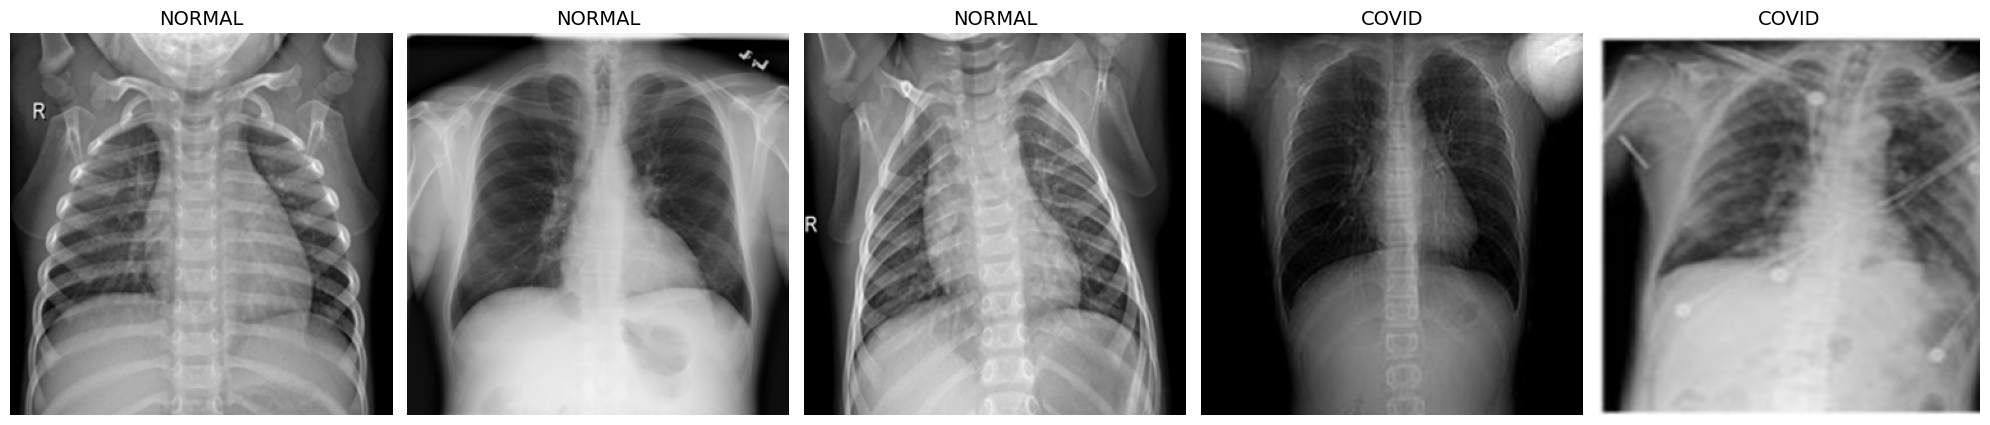

In [118]:
plotImages(sample_training_images[:5], sample_training_labels[:5]) #plots the 5 first images from the batch
#print(sample_training_labels[:5])

## 2. Developing baseline model

## 3. Fine-tuning a pre-trained model

## 4. Evaluating and describing models' performance and behaviour

In [1]:
print('test123')

test123
